Imports required for Lag-Llama prediction

In [3]:
%cd lag-llama

from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\Users\chris\OneDrive\Documents\EyesClear\Lag-Llama_Training\lag-llama


c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Lag Llama prediction function

In [4]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

Loading dataset from .csv

In [5]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

%cd ..
csv_file = "sol-usd-max.csv"
df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
%cd lag-llama
df

c:\Users\chris\OneDrive\Documents\EyesClear\Lag-Llama_Training
c:\Users\chris\OneDrive\Documents\EyesClear\Lag-Llama_Training\lag-llama


c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


,target,item_id
2020-04-11 00:00:00+00:00,0.957606,A
2020-04-12 00:00:00+00:00,0.784711,A
2020-04-13 00:00:00+00:00,0.875994,A
2020-04-14 00:00:00+00:00,0.786712,A
2020-04-15 00:00:00+00:00,0.666673,A
...,...,...
2024-07-27 00:00:00+00:00,183.084474,A
2024-07-28 00:00:00+00:00,184.668613,A
2024-07-29 00:00:00+00:00,184.788359,A
2024-07-30 00:00:00+00:00,182.543521,A


Setting up Pandas dataset

In [15]:
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")


backtest_dataset = dataset
#prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
prediction_length = 30  # Want to predict for last 30 days
num_samples = 3 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

Get predictions

In [16]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

C:\Users\chris\AppData\Local\Temp\ipykernel_34608\223013842.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device) # Us

Plot predictions

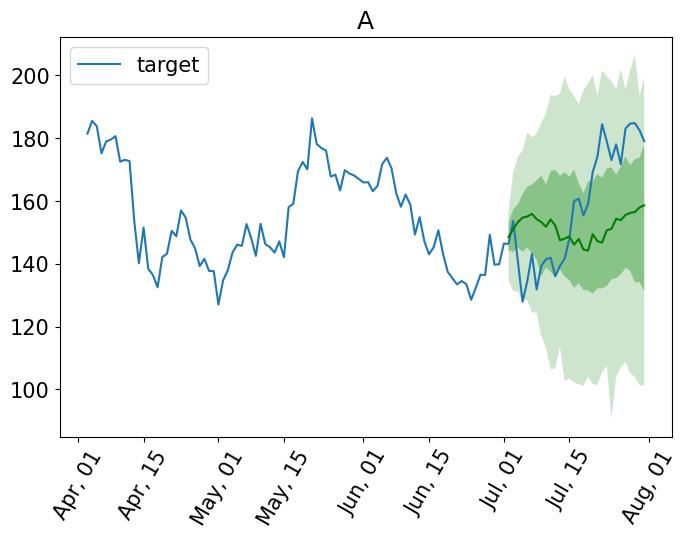

In [17]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()